#### Hacettepe University

#### Artificial Intelligence Engineering Department

#### Name - Surname :  Mehmet Alperen Ozcelik

## Detection of Clickbait Headlines

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")
import numpy as np

## • Part 1: Understanding the Data

In [2]:
df = pd.read_csv("Hw_Data_Cbait.csv")
print("Length of data: {}".format(len(df)))
df.head()

Length of data: 28800


,Headline,Clickbait
0,"Cuba Eliminates Mexico, 7-4, at Classic",0
1,This Is What Space Travel Really Looks Like,1
2,Which Mario Are You Based On Your Zodiac Sign,1
3,European oil companies stop trade with Iran,0
4,This Dachshund Is Determined To Sleep With His...,1


In [3]:
print(df.Clickbait.value_counts())

1    14403
0    14397
Name: Clickbait, dtype: int64


### Tokenizing

In [4]:
import nltk
from nltk import word_tokenize

tokens = df['Headline'].apply(word_tokenize)
tokens.head()

0    [Cuba, Eliminates, Mexico, ,, 7-4, ,, at, Clas...
1    [This, Is, What, Space, Travel, Really, Looks,...
2    [Which, Mario, Are, You, Based, On, Your, Zodi...
3    [European, oil, companies, stop, trade, with, ...
4    [This, Dachshund, Is, Determined, To, Sleep, W...
Name: Headline, dtype: object

### Advanced Preprocessing

In [5]:
import string
import inflect
from autocorrect import spell
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

def remove_non_ascii(tokens):
    
    sentence = []
    for word in tokens:
        encoded_string = word.encode('ascii', 'ignore')
        decode_string = encoded_string.decode()
        sentence.append(decode_string)
    return sentence

def lowercase(tokens):
    
    sentence = []
    for word in tokens:
        sentence.append(word.lower())
    return sentence

def remove_punctuation(tokens):
    
    sentence = []
    for word in tokens:
        new_word = word.translate(str.maketrans('', '', string.punctuation))
        if new_word != '':
            sentence.append(new_word)
    return sentence

def numbers_to_text(tokens):
    
    p = inflect.engine()
    sentence = []
    for word in tokens:
        if word.isdigit():
            text = p.number_to_words(word)
            sentence.append(text)
        else:
            sentence.append(word)
    return sentence

def lemmatize_verbs(tokens):
    
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in tokens:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def tokens_to_sentence(tokens):
    
    sentence = ' '.join(tokens)
    return sentence

def apply_all_methods(tokens):
    
    tokens = tokens.apply(remove_non_ascii)
    tokens = tokens.apply(lowercase)
    tokens = tokens.apply(remove_punctuation)
    tokens = tokens.apply(numbers_to_text)
    tokens = tokens.apply(lemmatize_verbs)
    return tokens

In [6]:
normalized_tokens = apply_all_methods(tokens)
normalized_tokens = normalized_tokens.apply(tokens_to_sentence)

### Dataframe Before Preprocessing

In [7]:
df.head()

,Headline,Clickbait
0,"Cuba Eliminates Mexico, 7-4, at Classic",0
1,This Is What Space Travel Really Looks Like,1
2,Which Mario Are You Based On Your Zodiac Sign,1
3,European oil companies stop trade with Iran,0
4,This Dachshund Is Determined To Sleep With His...,1


### Dataframe After Preprocessing

In [8]:
df['Headline'] = normalized_tokens
df.head()

,Headline,Clickbait
0,cuba eliminate mexico seventy-four at classic,0
1,this be what space travel really look like,1
2,which mario be you base on your zodiac sign,1
3,european oil company stop trade with iran,0
4,this dachshund be determine to sleep with his ...,1


In [9]:
real = df.loc[df.Clickbait == 0]
clickbait = df.loc[df.Clickbait == 1]

### 3 examples of specific keywords in clickbait headlines:

In [10]:
clickbait_spesific_words = clickbait.Headline.str.split(expand=True).stack().value_counts()
clickbait_spesific_words.head(3)

you    4979
be     4719
the    4478
dtype: int64

### 3 examples of specific keywords in real headlines:

In [11]:
real_spesific_words = real.Headline.str.split(expand=True).stack().value_counts()
real_spesific_words.head(3)

in    4128
to    3092
of    2410
dtype: int64

## • Part 2: Implementing Naive Bayes
 

### Naive Bayes Classifier

In [12]:
from sklearn.base import BaseEstimator

class NaiveBayesClassifier(BaseEstimator):
    
    def __init__(self, alpha = 0.1):
        
        self.alpha = alpha

    def predict(self, X):

        prior = np.asarray([len(i) / X.shape[0] for i in self.array])
        class_numerators = np.zeros(shape = (X.shape[0], prior.shape[0]))
        
        for i,value in enumerate(X):
            
            value_av = value.astype(bool)
            values = (self.counter_array / self.counter_array.sum())[:, value_av] ** value[value_av]
            class_numerators[i] = values.prod(axis = 1) * prior
            
        sum_of_numerators = class_numerators.sum(axis = 1).reshape(-1,1)
        probabilities = np.log(class_numerators / sum_of_numerators)
        prediction = probabilities.argmax(axis=1)
        
        return prediction
    
    def fit(self, X, y):
        
        self.array = np.asarray([X[y == i] for i in (0,1)])
        self.counter_array = np.asarray([i.sum(axis = 0) for i in self.array]) + self.alpha
        
        return self

### Bag of Words 

I create a Bag of Words (BoW) model which learns a vocabulary from all of the documents, then models each document by counting the number of times each word appears (which is unigram) and show with dictionary.

In [13]:
bow_dict = dict(df['Headline'].str.split(expand=True).stack().value_counts())
first10pairs = {k: bow_dict[k] for k in list(bow_dict.keys())[:10]}
first10pairs

{'to': 6012,
 'in': 5872,
 'the': 5746,
 'be': 5658,
 'you': 5000,
 'of': 4624,
 'and': 4033,
 'a': 3598,
 'for': 2850,
 's': 2760}

I use Count Vectorizer function to obtain BoW model first.
After the information given in part 3-a I reimplement the TF-IDF instead of CountVectorizer.

Then I printed the vectorized array as a dataframe to make it more understandable.


In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

"""
vectorizer = CountVectorizer()
vectorizer_array = vectorizer.fit_transform(df['Headline']).toarray()
"""

vectorizer = TfidfVectorizer()
tf_idf = vectorizer.fit_transform(df['Headline']).toarray()

tfidfconverter = TfidfTransformer()  
vector_array = tfidfconverter.fit_transform(tf_idf).toarray()  

vector_df = pd.DataFrame(vector_array, columns = vectorizer.get_feature_names())
vector_df

,00s,10000copy,10000th,1000blackgirls,1000th,100f,100k,100m,100mph,100th,...,zoom,zoombak,zotob,zoty,zowie,zuckerberg,zuma,zurawski,zurich,zykina
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## • Part 3:


### a) Analyzing effect of the words on prediction

While finding 3 examples of specific keywords in part-1, I directly benefited from the frequency of the words.

While finding the effect of the words on prediction, I took the average of the vectors for clickbait and real results after putting all sentences into TF-IDF vectorization.

And I reimplement the TF-IDF instead of CountVectorizer in part-2.

###### 10 words whose presence most strongly predicts that the headline is real, also 10 words whose absence most strongly predicts that the headline is clickbait

In [15]:
real_words_effect = vector_df.iloc[df[df.Clickbait == 0].index]
real_words_effect = real_words_effect.mean().sort_values(ascending = False)
real_words_effect.head(10)

in      0.013096
to      0.009141
of      0.008345
kill    0.008325
us      0.008213
for     0.007687
and     0.007050
at      0.006776
on      0.006095
two     0.005955
dtype: float64

###### I show the most effective words to predict headline is real with wordcloud

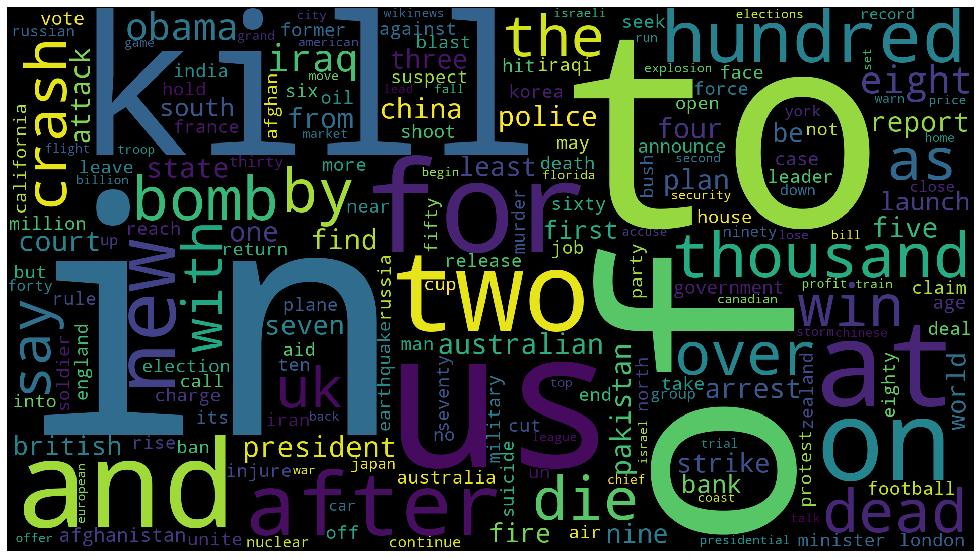

In [16]:
import seaborn as sns
from wordcloud import WordCloud

wordcloud = WordCloud(width=1920, height=1080).generate_from_frequencies(real_words_effect)

fig, ax = plt.subplots(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

###### 10 words whose presence most strongly predicts that the headline is clickbait, also 10 words whose absence most strongly predicts that the headline is real

In [17]:
clickbait_words_effect = vector_df.iloc[df[df.Clickbait == 1].index]
clickbait_words_effect = clickbait_words_effect.mean().sort_values(ascending = False)
clickbait_words_effect.head(10)

you       0.022429
be        0.017429
your      0.016836
the       0.016645
twenty    0.014429
that      0.012604
what      0.012372
this      0.011742
do        0.010945
things    0.010554
dtype: float64

###### I show the most effective words to predict headline is clickbait with wordcloud

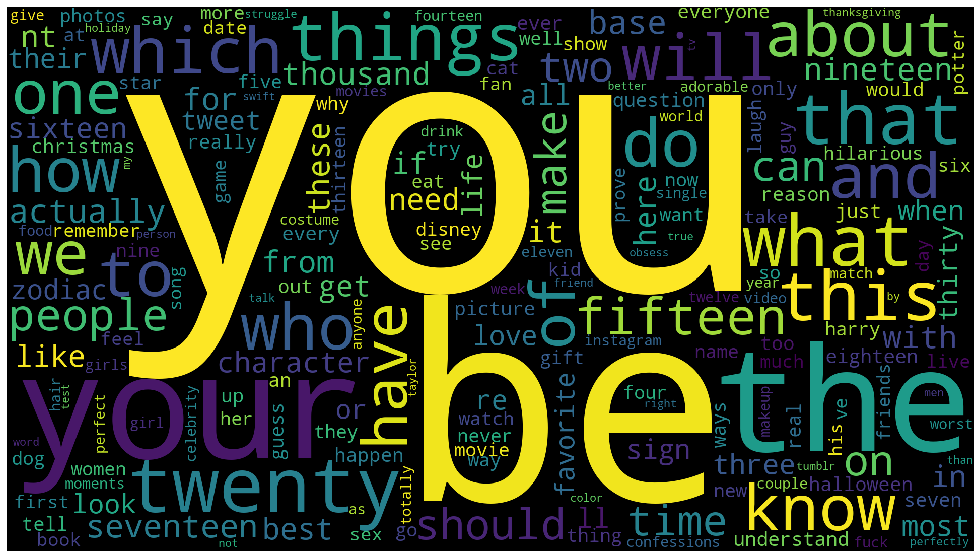

In [18]:
wordcloud = WordCloud(width=1920, height=1080).generate_from_frequencies(clickbait_words_effect)

fig, ax = plt.subplots(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### b) Stopwords

##### 10 non-stopwords that most strongly predict that the headline is real

In [19]:
real_words_without_sw = []
for i in real_words_effect.keys():
    if i not in stopwords.words('english'):
        real_words_without_sw.append(i)

real_words_without_sw[:10]

['kill',
 'us',
 'two',
 'new',
 'hundred',
 'thousand',
 'bomb',
 'dead',
 'die',
 'win']

###### I show the most effective non-stop words to predict headline is clickbait with wordcloud

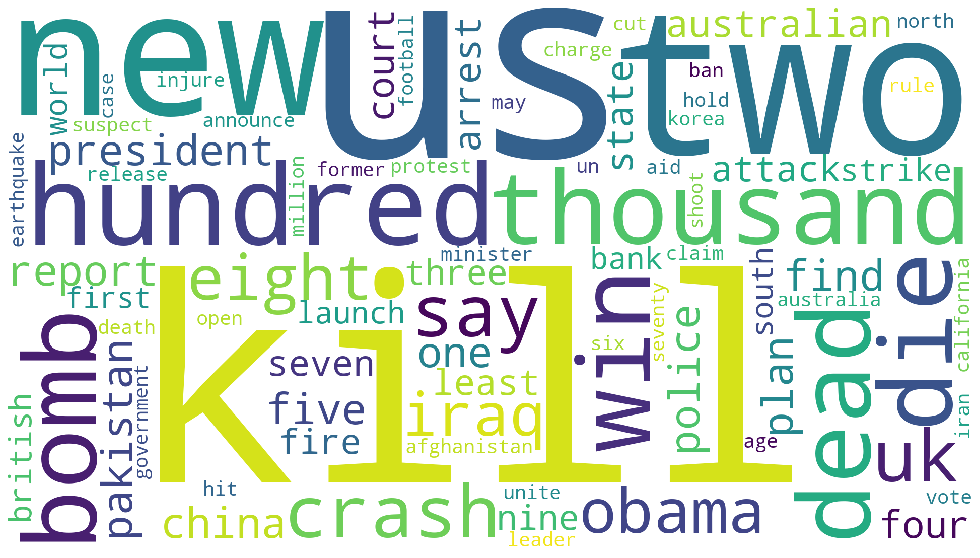

In [20]:
real_string=(" ").join(real_words_without_sw[:80])

wordcloud = WordCloud(width=1920, height=1080, background_color="white").generate(real_string)

fig, ax = plt.subplots(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

##### 10 non-stopwords that most strongly predict that the headline is clickbait

In [21]:
clickbait_words_without_sw = []
for i in clickbait_words_effect.keys():
    if i not in stopwords.words('english'):
        clickbait_words_without_sw.append(i)

clickbait_words_without_sw.pop(46)
clickbait_words_without_sw[:10]

['twenty',
 'things',
 'know',
 'one',
 'fifteen',
 'people',
 'make',
 'two',
 'time',
 'actually']

###### I show the most effective non-stop words to predict headline is clickbait with wordcloud

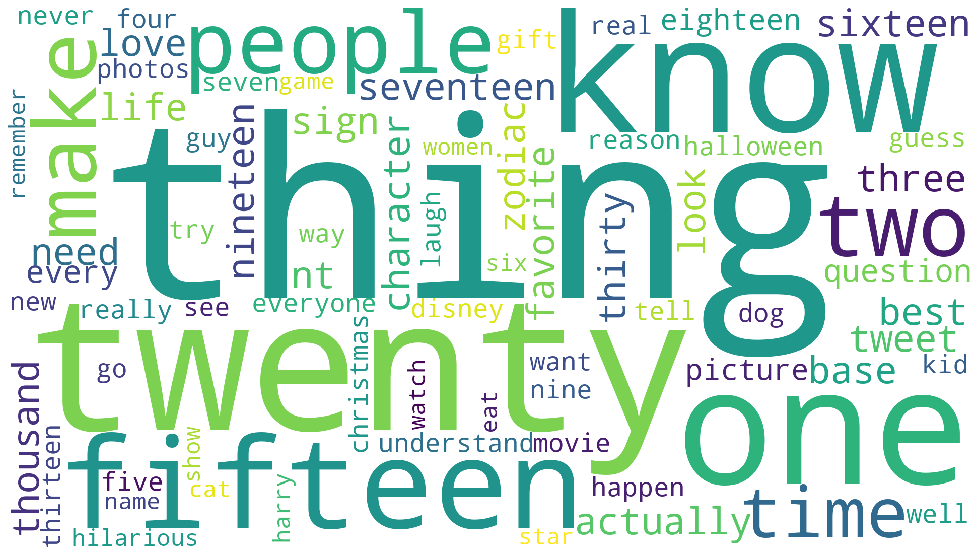

In [22]:
clickbait_string=(" ").join(clickbait_words_without_sw[:80])

wordcloud = WordCloud(width=1920, height=1080, background_color="white").generate(clickbait_string)

fig, ax = plt.subplots(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### c) Analyzing effect of the stopwords

##### Why might it make sense to remove stopwords when interpreting the model?

By removing the stopwors, we remove the low-level information from our text in order to give more focus to the important information. In order words, we can say that the removal of such words does not show any negative consequences on the model we train for our task.
Removal of stop words definitely reduces the dataset size and thus reduces the training time due to the fewer number of tokens involved in the training

##### Why might it make sense to keep stop words?
A word can be empty of meaning depending on the corpus we are using or any problem that we are analyzing. This means that any word can be a stopword depending on project.
In studies such as classification, stopwords may not be needed, but in some projects it is important to understand the sentence correctly and stopwords help us to find the context or the true meaning of a sentence. 


In this project, when I deleted the stopwords, I got 0.97 accuracy score, but when I didn't, I got 0.96.

## • Part 4: Calculation of Accuracy

###### It measures the success of classification method


In [23]:
def accuracy(y_test, predictions):
        
    correctly_classified = 0

    for i in range(len(y_test)):
        if(y_test.values[i] == predictions[i]):
            correctly_classified += 1

    accuracy = 100*(correctly_classified / len(predictions))
    return accuracy

## Try the Modal

###### I divided the data into 2 as train and test data.

In [24]:
X = df['Headline']
y = df['Clickbait']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33, shuffle=True, stratify=y)

###### I vectorized train and test data with TF-IDF vectorizing.

In [25]:
X_test_vectorized = vectorizer.transform(X_test).toarray()
X_train_vectorized = vectorizer.transform(X_train).toarray()

###### I do prediction by using the naive bayes classification method I wrote.

In [26]:
nb_model = NaiveBayesClassifier()
nb_model.fit(X_train_vectorized, y_train)
prediction = nb_model.predict(X_test_vectorized)

C:\Users\Casper\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [27]:
predictions_df = pd.DataFrame({"Headline": X_test, "Prediction":prediction, "y_test": y_test})
predictions_df.head()

,Headline,Prediction,y_test
15218,how well do you remember the word to dr dre s ...,1,1
1614,can you guess the ariana grande video from its...,1,1
8911,uconn roll into round of eight but only after ...,0,0
21616,we know your personality base on which toast y...,1,1
9288,do you know where these us tv show be set,1,1


###### Finally, I calculate the modal's accuracy

In [28]:
print("Naive Bayes Classifier Accuracy:")
print(accuracy(y_test,prediction))

Naive Bayes Classifier Accuracy:
97.01388888888889


## Summarize

In this project our goal is determine whether a headline is real or clickbait.
The clickbait and real headline numbers in our data were in a balanced way, which is very important in terms of overfitting.
First of all I split all the sentences into words, this process is called tokenizing.
I applied the basic preprocessing methods, which are widely used in NLP projects, to the tokens.
First, I got the most common words in two different headlines according to frequency. Afterwards, I applied TF-IDF to better see the effect of the words on the predictions.
After visualizing these words with wordcloud, I tested what changed when I used stopwords in my predictions.
Finally, I made my predictions using the naive bayes classifier class I wrote and calculated its accuracy.

## Test Part

In [29]:
kaggle_df = pd.read_csv("kaggle_data.csv")
print("Length of data: {}".format(len(kaggle_df)))
kaggle_df.head()

Length of data: 3200


,Headline,Clickbait
0,17 Very Real Struggles Of Christmas With Divor...,0
1,Australia records hottest year on record,0
2,California man convicted of murdering five fir...,0
3,Would You Smooch These Animals,0
4,MLB: Houston Astros fire manager Phil Garner a...,0


In [30]:
kaggle_tokens = kaggle_df['Headline'].apply(word_tokenize)
kaggle_tokens.head()

0    [17, Very, Real, Struggles, Of, Christmas, Wit...
1      [Australia, records, hottest, year, on, record]
2    [California, man, convicted, of, murdering, fi...
3                 [Would, You, Smooch, These, Animals]
4    [MLB, :, Houston, Astros, fire, manager, Phil,...
Name: Headline, dtype: object

In [31]:
kaggle_normalized_tokens = apply_all_methods(kaggle_tokens)
kaggle_normalized_tokens = kaggle_normalized_tokens.apply(tokens_to_sentence)

In [32]:
kaggle_tf_idf = vectorizer.fit_transform(kaggle_normalized_tokens).toarray()
kaggle_X = vectorizer.transform(X).toarray()
y = df['Clickbait']

In [33]:
nb_model = NaiveBayesClassifier()
nb_model.fit(kaggle_X, y)
kaggle_prediction = nb_model.predict(kaggle_tf_idf)

C:\Users\Casper\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [34]:
kaggle_df['Clickbait'] = kaggle_prediction

In [35]:
kaggle_df.head()

,Headline,Clickbait
0,17 Very Real Struggles Of Christmas With Divor...,1
1,Australia records hottest year on record,0
2,California man convicted of murdering five fir...,0
3,Would You Smooch These Animals,1
4,MLB: Houston Astros fire manager Phil Garner a...,0


In [36]:
kaggle_df.to_csv ("Kaggle_Predictions.csv", index=False, header=True)